# `InfiniteOpt.jl`: The Basics
Now that we are familiarized with Julia and `JuMP.jl`, let's talk about how `InfiniteOpt.jl` builds upon `JuMP.jl` to allow us to intuitively model infinite-dimensional optimization problems.

## Resources
Again, there is only so much that we can cover in a tutorial. Helpful resources include:
- The documentation: https://pulsipher.github.io/InfiniteOpt.jl/stable/.
- The paper: https://www.sciencedirect.com/science/article/pii/S0098135421003458?via%3Dihub 
- The open-source paper: https://arxiv.org/abs/2106.12689
- The `InfiniteOpt.jl` forum: https://github.com/pulsipher/InfiniteOpt.jl/discussions

## Optimal Control in `JuMP.jl`
To motivate `InfiniteOpt.jl`, let's consider modeling a simple optimal control problem in `JuMP.jl`.

### The Formulation
We'll take a look at a trajectory control problem:
$$
\begin{aligned}
&&\underset{x(t), v(t), u(t)}{\text{min}} &&& \int_{t \in \mathcal{D}_t} ||u(t)||_2^2 dt  \\
&&\text{s.t.} &&& \frac{dx}{dt} = v(t), && t \in \mathcal{D}_t\\
&&&&& \frac{dv}{dt} = u(t), && t \in \mathcal{D}_t\\
&&&&& x(t) = xw(t), && t \in \mathcal{D}_{tw} \\
&&&&& v(0) = 0
\end{aligned}
$$
Here position $x(t) \in \mathbb{R}^2$ and velocity $v(t) \in \mathbb{R}^2$ are state variables. The control variable $u(t) \in \mathbb{R}^2$ controls the acceleration (thrust) of the vehicle. Here we wish to plan a path that passes through all the waypoints $xw_i$ and minimizes the thrust used.

We cannot directly model this with `JuMP.jl` because the variables are functions of time $t$ and the formulation contains an integrals/derivatives. This is an infinite-dimensional problem.

### Discretize
We can transform it into a finite optimization `JuMP.jl` can handle by discretizing the variables over time and applying appropriate approximations to the integral/derivatives. 

We will transform the model via:
- let $\mathcal{D}_t = [0, T]$ and choose $n$ time steps such that $\Delta t = \frac{T}{n}$
- discretize each infinite variable (e.g., $\{x_t: t \in \{0, 1, \dots, n\}$)
- replace the integral with a sum over time
- approximate the derivatives via implicit Euler

With these steps, we obtain:
$$
\begin{aligned}
&&\underset{x_t, v_t, u_t}{\text{min}} &&& \sum_{t \in \{1, \dots, n\}} u_{1,t}^2 + u_{2,t}^2  \\
&&\text{s.t.} &&& x_{i,t+1} = x_{i,t} + \Delta t v_{i,t+1}, && i \in I, t \in \{0, 1, \dots, n-1\}\\
&&&&& v_{i,t+1} = v_{i,t} + \Delta t u_{i,t+1}, && i \in I, t \in \{0, 1, \dots, n-1\}\\
&&&&& x_{i,t} = xw_{i,t}, && i \in I, t \in \mathcal{D}_{tw} \\
&&&&& v_{i,0} = 0, && i \in I \\
\end{aligned}
$$

This is a discrete time model that we can formulate with `JuMP.jl`, let's try it out!

### Exercise: Optimal Control in `JuMP.jl`
**Problem**
- Implement the above model in `JuMP.jl`
- Complete the code below

In [1]:
using JuMP, HiGHS

# Set the parameters
n = 60
Δt = 60 / n 
I = 1:2

# Set the waypoint data
p = [1 4 6 1; 1 3 0 1]
Dtw = [0, 25, 50, 60]
xw = JuMP.Containers.DenseAxisArray(p, I, Dtw)

# Define the model (finish using the HiGHS optimizer)
model = Model(HiGHS.Optimizer)

# Add the variables (finish for each)
@variable(model, x[i ∈ I, t ∈ 0:n]) # x[i, t], i ∈ I, t ∈ {0, 1, ..., n}
@variable(model, v[i ∈ I, t ∈ 0:n]) # v[i, t], i ∈ I, t ∈ {0, 1, ..., n}
@variable(model, u[i ∈ I, t ∈ 1:n]) # u[i, t], i ∈ I, t ∈ {1, ..., n}

# Add the objective (finish)
@objective(model, Min, sum(u[1, t]^2 + u[2, t]^2 for t in 1:n)) # minimize Σ_{t ∈ 1:n} u[1, t]^2 + u[2, t]^2

# Add the constraints (finish)
@constraint(model, [i ∈ I, t ∈ 0:n-1], x[i, t+1] == x[i, t] + Δt * v[i, t+1]) # x[i, t+1] = x[i, t] + Δt v[i, t+1], i ∈ I, t ∈ {0, 1, ..., n-1}
@constraint(model, [i ∈ I, t ∈ 0:n-1], v[i, t+1] == v[i, t] + Δt * u[i, t+1]) # v[i, t+1] = v[i, t] + Δt u[i, t+1], i ∈ I, t ∈ {0, 1, ..., n-1}
@constraint(model, [i ∈ I, t ∈ Dtw], x[i, t] == xw[i, t]) # x[i, t] = xw[i, t], i ∈ I, t ∈ Dtw

# Add the initial conditions (finish)
fix.(v[:, 0], 0) # set v(0) = 0 hint: recall we can broadcast over a vector of variables

# Optimize the model
optimize!(model)

# Get the results (finish)
if has_values(model)
    x_opt = value.(x) # extract the values of x 
end;


Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [0e+00, 0e+00]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 6e+00]
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.004001, 372.000028, 114
100, 0.008006, 0.043793, 114
200, 0.010005, 0.043793, 114
300, 0.013006, 0.043793, 114
315, 0.014002, 0.043793, 114
Model   status      : Optimal
Objective value     :  4.3720356210e-02
HiGHS run time      :          0.01


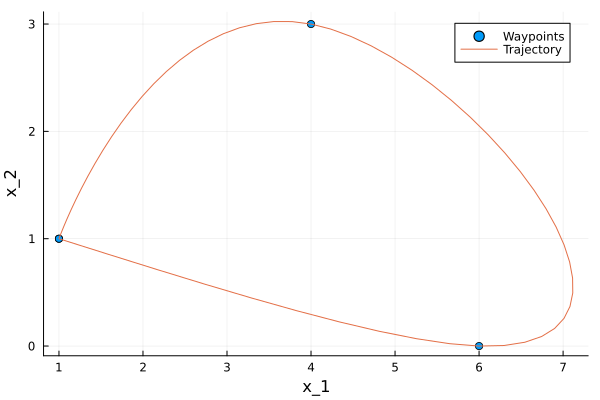

In [2]:
using Plots

# Plot the path
scatter(xw[1,:].data, xw[2,:].data, label = "Waypoints")
plot!(x_opt[1, :].data, x_opt[2, :].data, label = "Trajectory")
xlabel!("x_1")
ylabel!("x_2")

This works for this simple case, but we can start to think about some limitations:
- What if we want to implement a non-uniform grid?
- What about implementing (and switching between) derivative approximations (e.g., orthogonal collocation)?
- What about higher fidelity integral approximations?
- What about managing differing grid point between varied integral/derivative approximation schemes?
- What if we want to solve our model without discretization?
- What if we want to add uncertainty and/or PDE constraints?

We could resolve the majority of the above points by manually deriving a finite formulation for `JuMP.jl` each time, but this is cumbersome and prone to error. Hence, it is common to define the model once in discrete time and call it good.

However, characterizing models in discretized forms makes it likely for us to miss the insights we can gain from the infinite-dimensional form of the problem.

### Modeling in `InfiniteOpt.jl`
`InfiniteOpt.jl` is built upon our unifying abstraction for infinite-dimensional optimization. Moreover, it leverages `JuMP`'s architecture to have an intuitive interface.

Let's model the hovercraft optimal control problem in its native infinite-dimensional form using `InfiniteOpt.jl`:

In [4]:
using InfiniteOpt, HiGHS

# Set the parameters
v0 = zeros(2)
I = 1:2
p = [1 4 6 1; 1 3 0 1]
Dtw = [0, 25, 50, 60]
xw = JuMP.Containers.DenseAxisArray(p, I, Dtw)

# Create the model
model = InfiniteModel(HiGHS.Optimizer)

# Decalare t as an infinite parameter
@infinite_parameter(model, t ∈ [0, 60], num_supports = 61)

# Add the infinite variables
@variable(model, x[I], Infinite(t))
@variable(model, v[I], Infinite(t))
@variable(model, u[I], Infinite(t))

# Set the objective
@objective(model, Min, ∫(u[1]^2 + u[2]^2, t))

# Add the constraints
@constraint(model, ∂.(x, t) .== v)
@constraint(model, ∂.(v, t) .== u)
@constraint(model, [i ∈ I], v[i](0) == v0[i])
@constraint(model, [i ∈ I, tw ∈ Dtw], x[i](tw) == xw[i, tw])

# Optimize the model
optimize!(model)

# Get the results
if has_values(model)
    x_opt = value.(x)
end


Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [0e+00, 0e+00]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 6e+00]
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.001019, 249.000044, 116
100, 0.005943, 0.043758, 116
200, 0.008949, 0.043758, 116
300, 0.012021, 0.043758, 116
400, 0.014947, 0.043758, 116
497, 0.019946, 0.043758, 116
Model   status      : Optimal
Objective value     :  4.3685296066e-02
HiGHS run time      :          0.02


1-dimensional DenseAxisArray{Vector{Float64},1,...} with index sets:
    Dimension 1, 1:2
And data, a 2-element Vector{Vector{Float64}}:
 [1.0, 1.0096738980281634, 1.0289666539247435, 1.0578231780081901, 1.0961883301050024, 1.144006918101388, 1.2012236960194884, 1.2677833616209226, 1.3436305535404203, 1.428709847952302  …  5.650238034895405, 5.253196766570277, 4.814130286582207, 4.338292419626459, 3.8309367460146624, 3.297316625992073, 2.7426852256306833, 2.172295544035541, 1.5914004416016192, 1.0]
 [1.0, 1.0202691735547387, 1.0590434927421362, 1.1145588804771736, 1.1850512083967695, 1.2687562939075985, 1.3639098964850567, 1.468747713311583, 1.5815053743425487, 1.7004184368879331  …  0.021971808732314156, 0.0684977913482211, 0.13684975714656547, 0.22429951418390093, 0.3281188655840728, 0.44557960489291154, 0.573953510614444, 0.7105123400650357, 0.8525278226818718, 1.0]

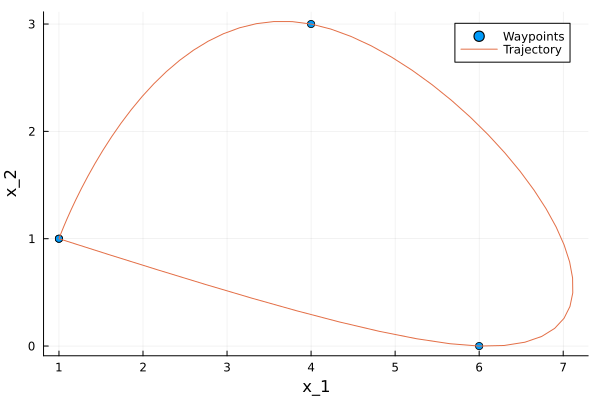

In [5]:
using Plots

scatter(xw[1,:].data, xw[2,:].data, label = "Waypoints")
plot!(x_opt[1], x_opt[2], label = "Trajectory")
xlabel!("x_1")
ylabel!("x_2")

We were able to express the model in its infinite form and `InfiniteOpt.jl` took care of the rest!

### What did we just do?
We will walk through each step of what we just did and learn about how `InfiniteOpt.jl` works.

First, we created a model object using `InfiniteModel`:

In [6]:
model = InfiniteModel(HiGHS.Optimizer)

An InfiniteOpt Model
Feasibility problem with:
  Finite parameters: 0
  Infinite parameters: 0
  Variables: 0
  Derivatives: 0
  Measures: 0
Transformation backend information: 
  Backend type: TranscriptionBackend
  Solver name: HiGHS
  Transformation built and up-to-date: false


We provide the `InfiniteModel` with an optimizer (one supported by `JuMP`) that will ultimately be used by the transformation backend to solve the model. More on that later...

Next, following our abstraction, we declare time $t \in [0, 60]$ as an infinite parameter using `@infinite_parameter` which follows a syntax similar to `@variable`:

In [7]:
@infinite_parameter(model, t ∈ [0, 60], num_supports = 61)

t

The `num_supports` keyword tells the backend optimizer model we would like to use `61` support (discretization) points to solve the model. We discuss more about the backends and the arguments they take later on.

Now that `t` is defined, let's add the infinite variables using `@variable`:

In [8]:
@variable(model, x[I], Infinite(t))
@variable(model, v[I], Infinite(t))
@variable(model, u[I], Infinite(t))

1-dimensional DenseAxisArray{GeneralVariableRef,1,...} with index sets:
    Dimension 1, 1:2
And data, a 2-element Vector{GeneralVariableRef}:
 u[1](t)
 u[2](t)

Here, the syntax for `@variable` is exactly the same as what we learned for `JuMP`. The only extra thing we do is add the `Infinite` tag containing the infinite parameters the variable depends on.

We define objective using `@objective` in like manner to `JuMP`:

In [9]:
@objective(model, Min, ∫(u[1]^2 + u[2]^2, t)) # ∫ is unicode from \int

integral{t in [0, 60]}[u[1](t)² + u[2](t)²]

Notice we are able to directly express the integral using `∫` (we can also use `integral`) with respect to the infinite parameter `t`. Its domain is inferred, but we can specify a subdomain and the approximation method we would like to use; more on that later.

Now we define ODEs using `@constraint`, expressing the derivatives with `∂` (can also use `deriv`) using `JuMP`'s broadcasting syntax for convenience:

In [10]:
@constraint(model, ∂.(x, t) .== v)
@constraint(model, ∂.(v, t) .== u)

1-dimensional DenseAxisArray{InfOptConstraintRef,1,...} with index sets:
    Dimension 1, 1:2
And data, a 2-element Vector{InfOptConstraintRef}:
 d/dt[v[1](t)] - u[1](t) == 0, for all t in [0, 60]
 d/dt[v[2](t)] - u[2](t) == 0, for all t in [0, 60]

All the same constraint types and forms supported by `JuMP.jl`, are also supported in `InfiniteOpt.jl`!

We also define the initial condition:

In [11]:
@constraint(model, [i ∈ I], v[i](0) == v0[i])

1-dimensional DenseAxisArray{InfOptConstraintRef,1,...} with index sets:
    Dimension 1, 1:2
And data, a 2-element Vector{InfOptConstraintRef}:
 v[1](0) == 0
 v[2](0) == 0

Notice that we can enforce this point constraint by calling `v[i](0)`, this creates a point variable of `v[i](t)` at time 0.

Next, we'll add the waypoint constraint:

In [12]:
@constraint(model, [i ∈ I, tw ∈ Dtw], x[i](tw) == xw[i, tw])

2-dimensional DenseAxisArray{InfOptConstraintRef,2,...} with index sets:
    Dimension 1, 1:2
    Dimension 2, [0, 25, 50, 60]
And data, a 2×4 Matrix{InfOptConstraintRef}:
 x[1](0) == 1  x[1](25) == 4  x[1](50) == 6  x[1](60) == 1
 x[2](0) == 1  x[2](25) == 3  x[2](50) == 0  x[2](60) == 1

Again we use the point variable syntax to enforce `x` at the waypoint time points `tw`.

With our model defined, we can interrogate it via pretty printing it using `latex_formulation`:

In [13]:
latex_formulation(model)

$$ \begin{aligned}
\min\quad & \int_{t \in [0, 60]}u_{1}(t)^2 + u_{2}(t)^2dt\\
\text{Subject to} \quad & \frac{d}{d t}\left[x_{1}(t)\right] - v_{1}(t) = 0, \quad\forall t \in [0, 60]\\
 & \frac{d}{d t}\left[x_{2}(t)\right] - v_{2}(t) = 0, \quad\forall t \in [0, 60]\\
 & \frac{d}{d t}\left[v_{1}(t)\right] - u_{1}(t) = 0, \quad\forall t \in [0, 60]\\
 & \frac{d}{d t}\left[v_{2}(t)\right] - u_{2}(t) = 0, \quad\forall t \in [0, 60]\\
 & v_{1}(0) = 0\\
 & v_{2}(0) = 0\\
 & x_{1}(0) = 1\\
 & x_{2}(0) = 1\\
 & x_{1}(25) = 4\\
 & x_{2}(25) = 3\\
 & x_{1}(50) = 6\\
 & x_{2}(50) = 0\\
 & x_{1}(60) = 1\\
 & x_{2}(60) = 1\\
\end{aligned} $$

In contrast to working with finite-time models, we can feasibly print interpretable models for real-world problems since the infinite-dimensional form is typically much more compact.

With the model all setup, we can optimize it via `optimize!`:

In [14]:
optimize!(model)

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [0e+00, 0e+00]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 6e+00]
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.001000, 249.000044, 116
100, 0.006995, 0.043758, 116
200, 0.010000, 0.043758, 116
300, 0.012999, 0.043758, 116
400, 0.016000, 0.043758, 116
497, 0.021996, 0.043758, 116
Model   status      : Optimal
Objective value     :  4.3685296066e-02
HiGHS run time      :          0.02


Behind the scenes, our infinite-dimensional model was transformed into a `JuMP.jl` model (in the transformation backend) via the default transformation backend `TranscriptionBackend` which used the 61 supports specified above. We can take a quick sneak peak at the transformation backend:

In [16]:
transformation_backend(model)

A TranscriptionBackend that uses a
A JuMP Model
Minimization problem with:
Variables: 610
Objective function type: QuadExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 494 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS

It is indeed a `JuMP.jl` model that uses the `HiGHS` optimizer (it also has some extra stuff to help it integrate seamlessly with the `InfiniteModel`). Note that pretty printing this discrete model would be impractical.

Finally, to complete this example we query the results using `value`:

In [17]:
value.(x)

1-dimensional DenseAxisArray{Vector{Float64},1,...} with index sets:
    Dimension 1, 1:2
And data, a 2-element Vector{Vector{Float64}}:
 [1.0, 1.0096738980281634, 1.0289666539247435, 1.0578231780081901, 1.0961883301050024, 1.144006918101388, 1.2012236960194884, 1.2677833616209226, 1.3436305535404203, 1.428709847952302  …  5.650238034895405, 5.253196766570277, 4.814130286582207, 4.338292419626459, 3.8309367460146624, 3.297316625992073, 2.7426852256306833, 2.172295544035541, 1.5914004416016192, 1.0]
 [1.0, 1.0202691735547387, 1.0590434927421362, 1.1145588804771736, 1.1850512083967695, 1.2687562939075985, 1.3639098964850567, 1.468747713311583, 1.5815053743425487, 1.7004184368879331  …  0.021971808732314156, 0.0684977913482211, 0.13684975714656547, 0.22429951418390093, 0.3281188655840728, 0.44557960489291154, 0.573953510614444, 0.7105123400650357, 0.8525278226818718, 1.0]

Notice, we get a vector of values for each infinite variable `x[i](t)`. These correspond to the discrete time values used in the reformulation which we can also retrieve using `value`:

In [18]:
value(t)

61-element Vector{Float64}:
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
  ⋮
 52.0
 53.0
 54.0
 55.0
 56.0
 57.0
 58.0
 59.0
 60.0

We can also make other queries as we typically do with `JuMP` models. For instance,

In [19]:
@show termination_status(model)
@show primal_status(model)
@show solve_time(model)
@show objective_value(model);

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
solve_time(model) = 0.021996021270751953
objective_value(model) = 0.04368529606639673


## The Building Blocks of `InfiniteModel`s
In this section, we go over the syntax for the modeling objects used in `InfiniteModel`s as per our unifying abstraction. 

Note that many of these constructs such as variables, expressions, objectives, constraints, etc. inherit all capabilities that `JuMP.jl`. `InfiniteOpt.jl` extends these to have additional capabilities needed for InfiniteOpt problems. Hence, our discussion will focus on these additional features.

### Infinite Models
The object behind it all, is the `InfiniteModel` itself. Typically, we will specify this with the optimizer we wish the default transformation backend (`TranscriptionBackend`) to use. We'll discuss working with transformation backends further below, but note that the following definitions are equivalent:

In [20]:
model = InfiniteModel(HiGHS.Optimizer, add_bridges = false)

model = InfiniteModel()
set_transformation_backend(model, TranscriptionBackend(HiGHS.Optimizer, add_bridges = false))

A `TranscriptionBackend` wraps around a `JuMP.Model`. Note that the arguments given to `InfiniteModel` are simply forwarded to the backend. We can also provide the transformation backend directly: 

In [21]:
model = InfiniteModel(TranscriptionBackend(HiGHS.Optimizer))

An InfiniteOpt Model
Feasibility problem with:
  Finite parameters: 0
  Infinite parameters: 0
  Variables: 0
  Derivatives: 0
  Measures: 0
Transformation backend information: 
  Backend type: TranscriptionBackend
  Solver name: HiGHS
  Transformation built and up-to-date: false


This is not necessary in this case since `TranscriptionBackend` is the default transformation backend type.

We can set the optimizer and attributes in like manner to `JuMP`:

In [22]:
model = InfiniteModel()
set_optimizer(model, HiGHS.Optimizer)
set_silent(model)
set_optimizer_attribute(model, "presolve", "on")

### Finite Parameters
As we saw, `JuMP.jl` has limited support for using changeable parameters. `InfiniteOpt.jl` provides finite parameters whose values can be changed and which can be used in any expression.

In [23]:
@finite_parameter(model, p == 42)
@finite_parameter(model, ps[i ∈ 1:2] == i)

2-element Vector{GeneralVariableRef}:
 ps[1]
 ps[2]

These parameters can be used anywhere in the model. We can query and modify the values with `value` and `set_value`, respectively:

In [27]:
@show InfiniteOpt.parameter_value(p)

set_value(p, 10)

@show InfiniteOpt.parameter_value(p);

InfiniteOpt.parameter_value(p) = 10.0
InfiniteOpt.parameter_value(p) = 10.0


We can also delete parameters from the model:

In [28]:
delete(model, ps[1])

For more information (including anonymous definition) see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/finite_parameter/

### Infinite Parameters
Infinite parameters serve as the core entity for defining infinite-dimensional modeling objects. They parameterize the domain of the problem (called the infinite domain). These are defined via `@infinite_parameter`:

In [29]:
@infinite_parameter(model, t ∈ [0, 10])

t

This will follow the syntax of `infinite_parameter(s)` in `infinite_domain`. In optimal control, we will typically be concerned time `t`, but we can also define other domain types like spatial position $x \in [-1, 1]^2$:

In [30]:
@infinite_parameter(model, x[1:2] in [-1, 1], independent = true, num_supports = 42, derivative_method = OrthogonalCollocation(3))

2-element Vector{GeneralVariableRef}:
 x[1]
 x[2]

Notice we can pass some keyword arguments as well:
- `independent` indicates whether the parameters are independent such that their domain is computed via the Cartesian product
- `num_supports` is an argument for the optimizer model indicating how many supports we'd like to use
- `derivative_method` is another optimizer model argument indicating how we want to approximate the derivatives that depend on these parameters.

We can also define random parameters with any distribution from `Distributions.jl`. For instance,

In [31]:
using Distributions

@infinite_parameter(model, ξ[1:4] ~ Dirichlet(4, 1), num_supports = 1000)

4-element Vector{GeneralVariableRef}:
 ξ[1]
 ξ[2]
 ξ[3]
 ξ[4]

This enables us to tackle stochastic programs as well!

We can also do some transformation backend related changes after definition. For instance:

In [32]:
add_supports(t, [0, 0.3, 4, 10])
set_derivative_method(t, FiniteDifference(Backward()))

Finally, we can delete infinite parameters if we want to:

In [33]:
delete(model, ξ)

#### Exercise: Create an Infinite Parameter
**Problem**
- Create an infinite parameter $\ell \in [-1, 1]$
- Specify that it should use 10 supports

In [34]:
# PUT CODE HERE
@infinite_parameter(model, ℓ ∈ [-1, 1], num_supports = 10)

ℓ

For more information (including anonymous definition) see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/parameter/

### Parameter Functions
Sometimes we may wish to embed some arbitrary Julia function of infinite parameters into our model. This is often the case with setpoints in optimal control and experimental data in parameter estimation.

While it is sometimes possible to represent these as explicit algebraic expressions, it is not always convenient or possible. To this end we provide, parameter functions via `@parameter_function` which follows a 
`JuMP`-like syntax:

In [35]:
function setpoint(t)
    if t <= 2
        return 1.2
    elseif t <= 5
        return 3.0
    elseif t <= 7
        return 1.6
    else
        return 3.5
    end
end

@parameter_function(model, mysetpoint == setpoint(t))

mysetpoint(t)

We can then use `mysetpoint` in any expression in `InfiniteOpt.jl`, and it will be handled appropriately when the model is transformed. Note that functions must return a scalar number.

Sometimes it is also convenient to use the functional definition API `parameter_function` with a Julia `do` block:

In [36]:
mysetpoint = parameter_function(t, name = "setpoint") do t
    if t <= 5
        return 2.0
    else 
        return 10.2
    end
 end

setpoint(t)

We can also define a collection of parameter functions that depend on some parent function:

In [37]:
parent(t, a) = sin(t)^a

@parameter_function(model, pfunc[i = 1:3] == t -> parent(t, i))

3-element Vector{GeneralVariableRef}:
 pfunc[1](t)
 pfunc[2](t)
 pfunc[3](t)

For more information (including anonymous definition) see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/expression/#par_func_docs.

### Variables
All variables can be made with `@variable` just like any `JuMP.jl` variable, the only difference is that we'll add an appropriate "tag" to it.

Let's begin with the most common: infinite variables.

These use the `Infinite` tag as we have already seen:

In [38]:
@variable(model, y >= 0, Infinite(t))

y(t)

Notice we can add bounds and conditions like normal.

Uniquely, with infinite variables we can provide a start (guess) that a function with the same input dimensions as the variable. For instance:

In [39]:
@variable(model, -1 <= w[i = 1:2] <= 1, Infinite(t), start = sin)
model[:w] # macro objects are registered like they are in JuMP

2-element Vector{GeneralVariableRef}:
 w[1](t)
 w[2](t)

Each $w_i(t)$ is set with an initial guess trajectory of $\sin(t)$.

Next, semi-infinite variables correspond to infinite variables whose domain is partially evaluated. We can define these using the `SemiInfinite` tag or via our functional syntax:

In [40]:
@variable(model, q, Infinite(t, x)) # an infinite variable 

@variable(model, q0, SemiInfinite(q, 0, x)) # macro definition

q0 = q(0, x) # functional definition

q0

Here `q0` acts as an alias Julia variable. Note that simply invoking the functional syntax at different time point will have intuitive printing:

In [41]:
q(1, x)

q(1, [x[1], x[2]])

Similarly, we can define point variables using the convenient functional syntax:

In [42]:
q(0, [-1, 1])
y(10)

y(10)

Alternatively, we can use `@variable` with the `Point` tag:

In [43]:
@variable(model, y0, Point(y, 0))

y0

Finally, we can define finite variables by simply using the `@variable` as one normally would in `JuMP.jl`: 

In [44]:
@variable(model, 0 ≤ z ≤ 4, Int)

z

Moreover, variables can be modified/queried/deleted in like manner to those in `JuMP.jl` with the same functions. Some examples include:
- `set_lower_bound`
- `fix`
- `set_binary`
- `UpperBoundRef`
- `set_start_value`
- `delete`

The only exception is that for infinite variables and derivatives the start values are queried/modified via `start_value_function` and `set_start_value_function`.

We can also query the infinite parameters that a variable depends on via `parameter_refs`:

In [45]:
parameter_refs(q)

(t, GeneralVariableRef[x[1], x[2]])

#### Exercise: Create Variables
**Problem**
- Add a variable $v(\ell) \in \{0, 1\}^2$
- Create a point variable $v_1(-1)$

In [46]:
# PUT CODE HERE
@variable(model, v[1:2], Infinite(ℓ), Bin)
v[1](-1)

v[1](-1)

For more information (including anonymous definitions) see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/variable/.

### Differential Operators
Differential operators capture how infinite variables vary with respect to infinite parameters. `InfiniteOpt.jl` currently supports derivative operators.

These can be defined via `deriv` (alternatively, `∂` produced with `\partial`):

In [47]:
∂(y, t) # make a first order derivative

d/dt[y(t)]

This can even operate directly on affine/quadratic expressions:

In [48]:
∂(2y * z - y^2 + 4y - z + 2, t)

2 d/dt[y(t)]*z - 2 d/dt[y(t)]*y(t) + 4 d/dt[y(t)]

Here the proper symbolic calculus rules are respected. We could even (unnecessarily) input an expression of infinite parameters:

In [49]:
∂(3t^2 + z * t - 3t + 4, t)

6 t + z - 3

General nonlinear expressions however are not supported:

In [50]:
∂(sin(y)^3, t)

ErrorException: Unsupported expression type GenericNonlinearExpr{GeneralVariableRef} for derivative definition.

To more efficiently parse large expression inputs and/or specify higher-order derivatives we can use `@deriv` (`@∂`):

In [51]:
@∂(q, t^2, x[1])

d/dx[1][d²/dt²[q(t, x)]]

Note the derivative operators are applied recursively.

We can also define derivatives via `@variable` with the `Deriv` tag if we want:

In [52]:
@variable(model, 0 <= dy <= 1, Deriv(y, t), start = 4)

dy(t)

This allows us to convenient create an alias Julia variable, add bounds, and an initial guess value if wanted. We can also apply the same modification/query functions to derivatives as we can to infinite variables. For instance:

In [53]:
fix(dy, 0, force = true)
set_lower_bound(∂(q, t), 42)

We can also create semi-infinite and/or point derivatives using the functional syntax or `@variable`:

In [54]:
dy(0)
∂(q, x[1])(0, x)

d/dx[1][q(t, x)](0, [x[1], x[2]])

#### Exercise: Create a Derivative
**Problem**
- Add $\frac{\partial^2}{\partial t^2}\left[4q^2(t, x) + q(t, x)\right]$

In [55]:
# PUT CODE HERE
@deriv(4q^2 + q, t^2)

8 d²/dt²[q(t, x)]*q(t, x) + 8 d/dt[q(t, x)]² + d²/dt²[q(t, x)]

For more information see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/derivative/.

### Expressions
`InfiniteOpt.jl` inherits the same expression syntax as `JuMP.jl`. Hence, for affine/quadratic expressions we can use `@expression` as normal:

In [56]:
@expression(model, my_expr, q^2 + y - 3)

q(t, x)² + y(t) - 3

We can also define expressions outside of macros (not recommended):

In [57]:
my_expr = q^2 + y - 3 # defining outside macros is not as performant

q(t, x)² + y(t) - 3

Now let's try out some nonlinear expressions:

In [58]:
@expression(model, nl_expr, sin(y)^2 / q)
nl_expr = sin(y)^2 / q

(sin(y(t)) ^ 2.0) / q(t, x)

Let's see some linear algebra with nonlinear expressions:

In [59]:
@variable(model, Q[1:2, 1:2]); @variable(model, W[1:2, 1:2]);

@expression(model, W * Q * v)

2-element Vector{GenericNonlinearExpr{GeneralVariableRef}}:
 (+(0.0) + ((W[1,1]*Q[1,1] + W[1,2]*Q[2,1]) * v[1](ℓ))) + ((W[1,1]*Q[1,2] + W[1,2]*Q[2,2]) * v[2](ℓ))
 (+(0.0) + ((W[2,1]*Q[1,1] + W[2,2]*Q[2,1]) * v[1](ℓ))) + ((W[2,1]*Q[1,2] + W[2,2]*Q[2,2]) * v[2](ℓ))

InfiniteOpt supports the same nonlinear operators as JuMP. Some require, the use of `SpecialFunctions`:

In [61]:
using SpecialFunctions

@show y^2.3 * gamma(y)

y ^ 2.3 * gamma(y) = (y(t) ^ 2.3) * gamma(y(t))


(y(t) ^ 2.3) * gamma(y(t))

We can query all the registered nonlinear operators via `all_nonlinear_operators`:

In [63]:
all_nonlinear_operators(model)

89-element Vector{Symbol}:
 :+
 :-
 :abs
 :sign
 :sqrt
 :cbrt
 :abs2
 :inv
 :log
 :log10
 ⋮
 :min
 :max
 :&&
 :||
 :<=
 :(==)
 :>=
 :<
 :>

Like `JuMP.jl` we can register unsupported operators. Here we use `@operator`:

In [68]:
@operator(model, lgop, 1, logerfcx) # `a` is an arbitrary symbol to indicate the argument structure
lgop(y)

lgop(y(t))

Here auto-differentiation is implied, but the gradient and the hessian functions can be given explicitly if wanted following `JuMP.jl`'s syntax.

For more information, see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/expression/.

### Measure Operators
Measure operators summarize an infinite variable/expression over a particular infinite parameter. `InfiniteOpt.jl` features a generic measure API, but more commonly users will use integrals and expectations.

Integrals and expectations can be defined with `integral` (`∫` from `\int`) and `expect` (`𝔼` from `\bbE`):

In [69]:
𝔼(q * y + y, t) 
∫(q * t - sin(q), t)

integral{t in [0, 10]}[(q(t, x)*t) - sin(q(t, x))]

Notice that the integral uses the full domain of the infinite parameter by default. We can truncate the domain by specifying the bounds:

In [70]:
∫(q, t, 0, 5)

integral{t in [0, 5]}[q(t, x)]

The expectation uses the appropriate pdf with random infinite parameters. With other infinite parameters (e.g., $t$) the default pdf is $\frac{1}{ub - lb}$, but we can specify a different one via the `pdf` keyword argument:

In [71]:
𝔼(y, t, pdf = t -> exp(-t)) # here the pdf acts as a discount factor

E{t in [0, 10]}[y(t)]

This introduces the notion of a time-valued pdf and expectation, we'll discuss this more later. 

Similarly, we can add a weighting function (mapping the infinite parameter to a scalar) to integrals via the `weight_func` argument:

In [72]:
∫(y, t, weight_func = t -> t^2)

integral{t in [0, 10]}[y(t)]

For increased efficiency with handling expressions, we also provide `@integral`, `@∫`, `@expect`, and `@𝔼`.

#### Exercise: Differentiate an Integral
**Problem**
- Define $\frac{\partial}{\partial x_1}\left[\int_{t \in [0, 10]} q(t, x)^2 dt\right]$

In [73]:
# PUT CODE HERE 
∂(∫(q^2, t), x[1])

d/dx[1][integral{t in [0, 10]}[q(t, x)²]]

We will discuss the approximation schemes for these in the transformation section.

For more information see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/measure/.

### Objectives
We define objectives using `@objective` like normal, typically these will contain measures that scalarize the cost function to be well-posed:

In [74]:
@objective(model, Min, ∫(sin(y), t))

integral{t in [0, 10]}[sin(y(t))]

One common mistake, is defining objectives without a fully reduced cost function (i.e., we don't measure all the infinite parameters):

In [75]:
@objective(model, Min, ∫(q, t))

ErrorException: Objective function cannot contain infinite parameters/variables.

Let's try that again:

In [76]:
@objective(model, Min, ∫(∫(q, x), t))

integral{t in [0, 10]}[integral{x in [-1, 1]^2}[q(t, x)]]

We can query/modify objectives just like one can in `JuMP.jl`.

For more information, see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/objective/.

### Constraints
Constraints are created in `InfiniteOpt.jl` using `@constraint`.

Let's try some out:

In [77]:
@constraint(model, sin(y) + z <= 0)
@constraint(model, Q >= 0, PSDCone()) # all the special constraints from JuMP
@constraint(model, [i ∈ 1:2], v[i]^2 + 5z >= 0) 
@constraint(model, sin.(v).^3 .== 0) # nonlinear broadcasting
@constraint(model, 5z * y + q^2 <= 3)

5 z*y(t) + q(t, x)² <= 3, for all t in [0, 10], x[1] in [-1, 1], x[2] in [-1, 1]

Note that while it is possible to create nonlinear vector constraints in `InfiniteOpt.jl`, these are not currently supported by any transformation backend.

Commonly, we wish to enforce point constraints (e.g., boundary conditions), this can be accomplished using our functional point variable syntax:

In [78]:
@constraint(model, initial, y(0) == 42)

initial : y0 == 42

We can also define constraints whose domain is restricted to a portion of the infinite domain by adding `DomainRestrictions`:

In [79]:
@constraint(model, y + 2z ≤ 0, DomainRestrictions(t => [2, 5]))

y(t) + 2 z <= 0, for all t in [2, 5]

For now this is limited to ranges, but development is underway to accept arbitrary logic. 

We can query/modify/delete constraints just like we can in `JuMP.jl` using the same methods. For instance:

In [80]:
delete(model, initial)

#### Exercise: Constraints
**Problem**
- Add $\sum_{i \in \{1, 2\}} \tan(v_i(\ell)) \geq 42, \; \forall \ell \in [0, 1]$

In [81]:
# PUT CODE HERE
@constraint(model, sum(tan(v[i]) for i ∈ 1:2) ≥ 42, DomainRestrictions(ℓ => [0, 1]))

(tan(v[1](ℓ)) + tan(v[2](ℓ))) - 42.0 >= false, for all ℓ in [0, 1]

For more information, see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/constraint/.

## Transformations and Solution
`InfiniteOpt` is based on a transformation paradigm. This is used to solve `InfiniteModel`s. In this section, we will highlight how this is done.

### The Transformation Backend Framework
As we highlighted above, `InfiniteModel`s contain an transformation backend that is ultimately used to solve the infinite models.

![transform](figures/transformation.png)

Transformation backends store the transformed version of an `InfiniteModel` that can be handled by other tools (e.g., JuMP). Moreover, they contain mapping information to support seamless interaction with `InfiniteModel`s.

Transformation backends are queried via `transformation_backend` and are populated whenever `build_transformation_backend!` is called:

In [82]:
model = InfiniteModel(HiGHS.Optimizer)
@show transformation_backend(model)
println()

@infinite_parameter(model, t ∈ [0, 1], num_supports = 3)
@variable(model, y ≥ 0, Infinite(t))
@objective(model, Min, ∫(y, t))

build_transformation_backend!(model)

@show transformation_backend(model)

latex_formulation(transformation_model(model))

transformation_backend(model) = A TranscriptionBackend that uses a
A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS

transformation_backend(model) = A TranscriptionBackend that uses a
A JuMP Model
Minimization problem with:
Variables: 3
Objective function type: AffExpr
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 3 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS


$$ \begin{aligned}
\min\quad & 0.25 y(support: 1) + 0.5 y(support: 2) + 0.25 y(support: 3)\\
\text{Subject to} \quad & y(support: 1) \geq 0\\
 & y(support: 2) \geq 0\\
 & y(support: 3) \geq 0\\
\end{aligned} $$

We'll discuss the particulars of `TranscriptionBackend` below, but here we can see how the model is transformed and stored.

### Direct Transcription via `TranscriptionBackend`
The default transformation backend in `InfiniteOpt.jl` is `TranscriptionBackend` which can apply a suite of discretization techniques to transform `InfiniteModel`s. These all fall under the umbrella of direct transcription. This principal is illustrated below:

![transcription](../figures/transcription.png)

The general methodology for applying direct transcription is the following:
1. Define supports (discretization points) for each infinite parameter
2. Add any additional supports needed for derivative/integral approximation (e.g., collocation points)
3. Generate the appropriate transcription variables
4. Expand measures via an appropriate approximation scheme (e.g., trapezoid rule)
5. Replace remaining infinite variables with transcription variables over each support combination
6. Transcribe infinite constraints over all support combinations they depend on
7. Add on auxiliary derivative approximation equations for derivative variables

For instance, consider the simple space-time model:
$$
\begin{aligned}
	&&\min_{y(t), g(t, x)} &&& \int_0^{10} y^2(t) dt \\
	&&\text{s.t.} &&& y(0) = 1 \\
	&&&&& \int_{x \in [-1, 1]^2} \frac{\partial g(t, x)}{\partial t} dx = 42, && \forall t \in [0, 10] \\
  &&&&& 3g(t, x) + 2y^2(t) \leq 2, && \forall t \in T, \ x \in [-1, 1]^2. \\
\end{aligned}
$$
Define supports for the infinite parameters $t$ and $x$:
$$
t \in \{0, 10\}, \;\;\;\;\; x \in \{[-1, -1]^T, [-1, 1]^T, [1, -1]^T, [1, 1]^T\}
$$
Now we expand the integral measures via a trapezoid rule:
$$
\begin{aligned}
	&&\min_{y(t), g(t, x)} &&& 5y^2(0) + 5y^2(10) \\
	&&\text{s.t.} &&& y(0) = 1 \\
  &&&&& g(0, x) = 0 \\
	&&&&& \frac{\partial g(t, [-1, -1])}{\partial t} + \frac{\partial g(t, [-1, 1])}{\partial t} + \frac{\partial g(t, [1, -1])}{\partial t} + \frac{\partial g(t, [1, 1])}{\partial t} = 42, && \forall t \in [0, 10] \\
  &&&&& 3g(t, x) + 2y^2(t) \leq 2, && \forall t \in T, \ x \in [-1, 1]^2. \\
\end{aligned}
$$
Now we need to transcribe the remaining infinite variables and constraints:
$$
\begin{aligned}
	&&\min_{y(t), g(t, x)} &&& 5y^2(0) + 5y^2(10) \\
	&&\text{s.t.} &&& y(0) = 1 \\
  &&&&& g(0, [-1, -1]) = 0 \\
  &&&&& g(0, [-1, 1]) = 0 \\
  &&&&& g(0, [1, -1]) = 0 \\
  &&&&& g(0, [1, 1]) = 0 \\
	&&&&& \frac{\partial g(0, [-1, -1])}{\partial t} + \frac{\partial g(0, [-1, 1])}{\partial t} + \frac{\partial g(0, [1, -1])}{\partial t} + \frac{\partial g(0, [1, 1])}{\partial t} = 42\\
  &&&&& \frac{\partial g(10, [-1, -1])}{\partial t} + \frac{\partial g(10, [-1, 1])}{\partial t} + \frac{\partial g(10, [1, -1])}{\partial t} + \frac{\partial g(10, [1, 1])}{\partial t} = 42\\
  &&&&& 3g(0, [-1, -1]) + 2y^2(0) \leq 2 \\
  &&&&& 3g(0, [-1, 1]) + 2y^2(0) \leq 2 \\
  &&&&& \vdots \\
  &&&&& 3g(10, [1, 1]) + 2y^2(10) \leq 2.
\end{aligned}
$$
Finally, we tag on the auxiliary derivative variable equations determined by backward finite difference:
$$
\begin{aligned}
&&& g(10, [-1, -1]) = g(0, [-1, -1]) + 10\frac{\partial g(10, [-1, -1])}{\partial t} \\
&&& g(10, [-1, 1]) = g(0, [-1, 1]) + 10\frac{\partial g(10, [-1, 1])}{\partial t} \\
&&& g(10, [1, -1]) = g(0, [1, -1]) + 10\frac{\partial g(10, [1, -1])}{\partial t} \\
&&& g(10, [1, 1]) = g(0, [1, 1]) + 10\frac{\partial g(10, [1, 1])}{\partial t}
\end{aligned}
$$

Let's see how `InfiniteOpt.jl` does:

In [85]:
# Initialize model
inf_model = InfiniteModel()

# Define parameters and supports
@infinite_parameter(inf_model, t in [0, 10], supports = [0, 5, 10])
@infinite_parameter(inf_model, x[1:2] in [-1, 1], supports = [-1, 1], independent = true)

# Define variables
@variable(inf_model, y, Infinite(t))
@variable(inf_model, g, Infinite(t, x))

# Set the objective
@objective(inf_model, Min, ∫(y^2, t))

# Define the constraints
@constraint(inf_model, y(0) == 1)
@constraint(inf_model, con, g(0, x) == 0)
@constraint(inf_model, ∫(∫(∂(g, t), x[1]), x[2]) == 42)
@constraint(inf_model, 3g + y^2 <= 2)

# Print the infinite model
latex_formulation(inf_model)

$$ \begin{aligned}
\min\quad & \int_{t \in [0, 10]}y(t)^2dt\\
\text{Subject to} \quad & y(0) = 1\\
 & g(0, [x[1], x[2]]) = 0, \quad\forall x_{1} \in [-1, 1], x_{2} \in [-1, 1]\\
 & \int_{x_{2} \in [-1, 1]}\int_{x_{1} \in [-1, 1]}\frac{\partial}{\partial t}\left[g(t, x)\right]dxdx = 42, \quad\forall t \in [0, 10]\\
 & y(t)^2 + 3 g(t, x) \leq 2, \quad\forall t \in [0, 10], x_{1} \in [-1, 1], x_{2} \in [-1, 1]\\
\end{aligned} $$

In [86]:
build_transformation_backend!(inf_model)

trans_model = transformation_model(inf_model)
latex_formulation(trans_model)

$$ \begin{aligned}
\min\quad & 2.5 y(support: 1)^2 + 5 y(support: 2)^2 + 2.5 y(support: 3)^2\\
\text{Subject to} \quad & y(support: 1) = 1\\
 & g(support: 1) = 0\\
 & g(support: 4) = 0\\
 & g(support: 7) = 0\\
 & g(support: 10) = 0\\
 & d/dt[g(t, x)](support: 1) + d/dt[g(t, x)](support: 4) + d/dt[g(t, x)](support: 7) + d/dt[g(t, x)](support: 10) = 42\\
 & d/dt[g(t, x)](support: 2) + d/dt[g(t, x)](support: 5) + d/dt[g(t, x)](support: 8) + d/dt[g(t, x)](support: 11) = 42\\
 & d/dt[g(t, x)](support: 3) + d/dt[g(t, x)](support: 6) + d/dt[g(t, x)](support: 9) + d/dt[g(t, x)](support: 12) = 42\\
 & g(support: 1) - g(support: 2) + 5 d/dt[g(t, x)](support: 2) = 0\\
 & g(support: 2) - g(support: 3) + 5 d/dt[g(t, x)](support: 3) = 0\\
 & g(support: 4) - g(support: 5) + 5 d/dt[g(t, x)](support: 5) = 0\\
 & g(support: 5) - g(support: 6) + 5 d/dt[g(t, x)](support: 6) = 0\\
 & g(support: 7) - g(support: 8) + 5 d/dt[g(t, x)](support: 8) = 0\\
 & g(support: 8) - g(support: 9) + 5 d/dt[g(t, x)](support

This exactly matches what we did by hand! The support combinations are computed automatically. We can determine their values via `supports`:

In [87]:
@show supports(y)

supports(g)

supports(y) = Tuple[(0.0,), (5.0,), (10.0,)]


12-element Vector{Tuple}:
 (0.0, [-1.0, -1.0])
 (5.0, [-1.0, -1.0])
 (10.0, [-1.0, -1.0])
 (0.0, [1.0, -1.0])
 (5.0, [1.0, -1.0])
 (10.0, [1.0, -1.0])
 (0.0, [-1.0, 1.0])
 (5.0, [-1.0, 1.0])
 (10.0, [-1.0, 1.0])
 (0.0, [1.0, 1.0])
 (5.0, [1.0, 1.0])
 (10.0, [1.0, 1.0])

The tuple order corresponds to the infinite parameters of each, which we can check via `parameter_refs`:

In [88]:
@show parameter_refs(y)

@show parameter_refs(g);

parameter_refs(y) = (t,)
parameter_refs(g) = (t, GeneralVariableRef[x[1], x[2]])


We map the `InfiniteModel` modeling objects to the underlying ones via `transformation_variable`, `transformation_expression`, and `transformation_constraint`:

In [89]:
@show transformation_variable(y)
@show transformation_expression(y^2 + 2)
transformation_constraint(con)

transformation_variable(y) = VariableRef[y(support: 1), y(support: 2), y(support: 3)]
transformation_expression(y ^ 2 + 2) = AbstractJuMPScalar[y(support: 1)² + 2, y(support: 2)² + 2, y(support: 3)² + 2]


4-element Vector{ConstraintRef}:
 con(support: 1) : g(support: 1) == 0
 con(support: 2) : g(support: 4) == 0
 con(support: 3) : g(support: 7) == 0
 con(support: 4) : g(support: 10) == 0

#### Integral Approximations
A wide variety of integral approximations (14 in total) are currently supported. These include:
- Trapezoid rule (default)
- Gaussian quadrature
- Monte Carlo sampling

The full list is provided at https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/measure/#Evaluation-Methods.

Let's try specifying an integral that uses an appropriate Gauss quadrature scheme:

In [90]:
model = InfiniteModel()
@infinite_parameter(model, t ∈ [0, 1])
@variable(model, y, Infinite(t))

my_int = ∫(y, t, eval_method = Quadrature(), num_nodes = 4)

integral{t in [0, 1]}[y(t)]

That's it, `InfiniteOpt.jl` has a sophisticated support management system to properly keep track of where all supports come from and where they will be needed for transcription. 

We can interrogate what the approximation will look like using `expand`:

In [91]:
expand(my_int)

0.08333333333333333 y(0) + 0.41666666666666663 y(0.27639320225) + 0.41666666666666663 y(0.72360679775) + 0.08333333333333333 y(1)

Note that `expand` should be avoided with models you intent to solve, since point/semi-infinite variables are added to the model prematurely to facilitate the preview. This is only intended as a method for curious users.

#### Derivative Approximations
For consistency, derivative approximation methods are associated with the infinite parameters the derivatives depend on. We can specify them when adding infinite parameters or later on via `set_derivative_method`. Currently, 4 such methods are supported:
- Forward finite difference
- Central finite difference
- Backward finite difference (default)
- Orthogonal collocation over finite elements with Lobatto quadrature

To set orthogonal collocation with 3 nodes per finite element, we would write:

In [92]:
model = InfiniteModel()
@infinite_parameter(model, t ∈ [0, 1], num_supports = 3, derivative_method = OrthogonalCollocation(3))
@variable(model, y, Infinite(t))

@constraint(model, ∂(y, t) >= 0)
@constraint(model, y(0) == 0);

This will use 3 supports to construct the finite element boundaries (giving 2 finite elements). Later on collocation points will be added (1 extra per element). We can preview the derivative approximations via `evaluate_all_derivatives!` and `derivative_constraints`:

In [93]:
evaluate_all_derivatives!(model)
derivative_constraints(∂(y, t))

4-element Vector{InfOptConstraintRef}:
 0.375 d/dt[y(t)](0.25) - 0.125 d/dt[y(t)](0.5) - y(0.25) + y(0) == 0
 0.5 d/dt[y(t)](0.25) - y(0.5) + y(0) == 0
 0.375 d/dt[y(t)](0.75) - 0.125 d/dt[y(t)](1) - y(0.75) + y(0.5) == 0
 0.5 d/dt[y(t)](0.75) - y(1) + y(0.5) == 0

Again, these modify `model` in place and should not be used with models we actually want to solve.

For more information, see https://pulsipher.github.io/InfiniteOpt.jl/stable/guide/derivative/#Derivative-Evaluation.

### Transcription Solutions
Querying the solution of an `InfiniteModel` is done in similar manner to `JuMP` models.

Let's begin by creating and solving a model:

In [94]:
model = InfiniteModel(HiGHS.Optimizer)
set_silent(model)
@infinite_parameter(model, t in [0, 10], num_supports = 10)
@variable(model, y >= 0, Infinite(t))
@variable(model, z >= 0)
@objective(model, Min, 2z)
@constraint(model, c1, z >= y)
@constraint(model, c2, y(0) == 42)
optimize!(model)

We can do all the model based queries in exactly the same way to `JuMP`:

In [95]:
@show termination_status(model)
@show primal_status(model)
@show dual_status(model)
@show has_values(model)
@show objective_value(model)
@show solve_time(model);

termination_status(model) = MathOptInterface.OPTIMAL
primal_status(model) = MathOptInterface.FEASIBLE_POINT
dual_status(model) = MathOptInterface.FEASIBLE_POINT
has_values(model) = true
objective_value(model) = 84.0
solve_time(model) = 0.0


We can query the values of the variables and constraints using `value`

In [96]:
@show value(z)
@show value(y)
@show value(c1)
@show value(c2);

value(z) = 42.0
value(y) = [42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
value(c1) = [0.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0]
value(c2) = 42.0


These correspond to the values of the transcription variables/constraints.

We can also query the constraints as normal with methods like `dual` and `shadow_price`:

In [97]:
@show shadow_price(c1)
@show shadow_price(c2);

shadow_price(c1) = [-2.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
shadow_price(c2) = -2.0


For linear models, we can even get the sensitivity report:

In [98]:
report = lp_sensitivity_report(model)
@show report[c2]
report[c1]

report[c2] = (-42.0, Inf)


10-element Vector{Tuple{Float64, Float64}}:
 (-42.0, Inf)
 (-Inf, 42.0)
 (-Inf, 42.0)
 (-Inf, 42.0)
 (-Inf, 42.0)
 (-Inf, 42.0)
 (-Inf, 42.0)
 (-Inf, 42.0)
 (-Inf, 42.0)
 (-Inf, 42.0)

We can also interrogate the transcription backend directly:

In [101]:
solution_summary(transformation_model(model))

* Solver : HiGHS

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "kHighsModelStatusOptimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 8.40000e+01
  Objective bound    : 0.00000e+00
  Relative gap       : Inf
  Dual objective value : 8.40000e+01

* Work counters
  Solve time (sec)   : 0.00000e+00
  Simplex iterations : 0
  Barrier iterations : 0
  Node count         : -1


### Other Solution Approaches
As we will discuss in the last module today, `InfiniteOpt.jl` is modular and new transformation approaches can readily be added.

Currently, `TranscriptionBackend` is the most established. There is also the experimental `ExaTranscriptionBackend` provided by the `InfiniteExaModels` package which accelerates NLP solutions on CPU and GPU!